### Support Vector Machine (SVM)

SVM is a supervised machine learning algorithm used for classification. It finds a hyperplane (decision boundary) that:
1. Separates classes (e.g., $y_i \in \{-1, +1\}$).
2. Maximizes the margin, which is the distance between the hyperplane and the nearest points from each class.

For hard-margin SVM, all points must:
- Be correctly classified.
- Lie outside the margin boundaries.

The goal is to maximize the separating hyperplace's margin (defined by w, b), in order to classify datapoints into decision boundaries.  

$$
\min_{w \in \mathbb{R}^2, b \in \mathbb{R}} \frac{1}{2} \|w\|^2
$$

#### Constraints:
$$
y_i (w^\top x_i + b) \geq 1, \quad \forall i
$$

Here:
- $x_i \in \mathbb{R}^2$: Feature vector for the $i$-th sample.
- $y_i \in \{-1, +1\}$: Class label for the $i$-th sample.
- $w \in \mathbb{R}^2$: Weight vector of the hyperplane.
- $b \in \mathbb{R}$: Bias term.

The solution provides $w$ (the orientation of the decision boundary) and $b$ (the offset).

/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_7008/2948795951.py:42: RuntimeWarning: divide by zero encountered in divide
  x2_vals_sklearn = (-w_sklearn[0] * x1_vals - b_sklearn) / w_sklearn[1]


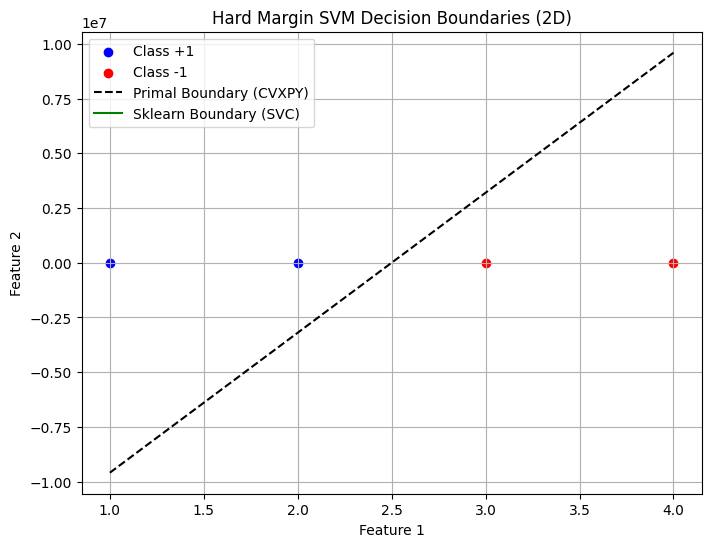

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from sklearn.svm import SVC

# Extend to 2D
np.random.seed(42)
X = np.array([[1, 2], [2, 3], [3, 3], [4, 5]])  # Two features (2D)
y = np.array([1, 1, -1, -1])  # Corresponding binary labels

# Primal Hard-Margin SVM Formulation using CVXPY
w = cp.Variable(2)
b = cp.Variable()
constraints = [y[i] * (w @ X[i] + b) >= 1 for i in range(len(y))]
objective = cp.Minimize(0.5 * cp.norm(w)**2)
problem = cp.Problem(objective, constraints)
problem.solve()

# Extract primal solution
w_primal = w.value
b_primal = b.value

# Solve using sklearn's SVC for comparison
svm = SVC(kernel='linear', C=1e10)  # Very high C for hard margin
svm.fit(X, y)
w_sklearn = svm.coef_[0]  # SVC provides w
b_sklearn = svm.intercept_[0]

# Visualization
plt.figure(figsize=(8, 6))

# Scatter plot of data points
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class +1')
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1')

# Plot decision boundary from primal solution
x1_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
x2_vals_primal = (-w_primal[0] * x1_vals - b_primal) / w_primal[1]
plt.plot(x1_vals, x2_vals_primal, 'k--', label='Primal Boundary (CVXPY)')

# Plot decision boundary from sklearn's SVC
x2_vals_sklearn = (-w_sklearn[0] * x1_vals - b_sklearn) / w_sklearn[1]
plt.plot(x1_vals, x2_vals_sklearn, 'g-', label='Sklearn Boundary (SVC)')

# Labels, legend, and grid
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Hard Margin SVM Decision Boundaries (2D)')
plt.legend()
plt.grid(True)
plt.show()


### Soft-Margin SVM with Nonlinear Kernel

### Primal Problem

#### Objective:
$$
\min_{w, b, \xi} \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i
$$

#### Constraints:
1. Classification with Slack:
$$ 
y_i \big( w^\top \phi(x_i) + b \big) \geq 1 - \xi_i, \quad \forall i
$$
- $\phi(x_i)$: Feature mapping to a higher-dimensional space.
- $\xi_i \geq 0$: Allows margin violations.

2. Non-Negative Slack Variables:
$$
\xi_i \geq 0, \quad \forall i
$$

### Dual Problem

#### Objective:
$$
\max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(x_i, x_j)
$$
Where $K(x_i, x_j) = \phi(x_i)^\top \phi(x_j)$ is the kernel function.

#### Constraints:
1. Bounds:
$$
0 \leq \alpha_i \leq C, \quad \forall i
$$
2. Equality:
$$
\sum_{i=1}^n \alpha_i y_i = 0
$$

This formulation efficiently handles nonlinear decision boundaries using kernel functions.

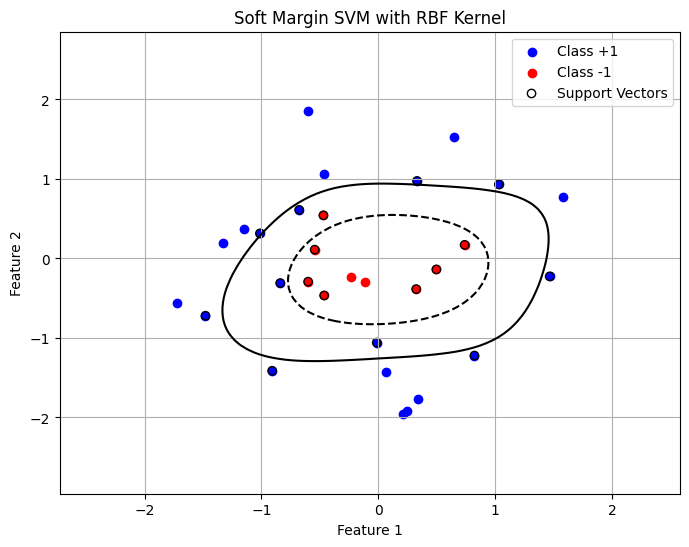

Alpha values: [ 5.46891402e-01 -3.51462767e-23  1.12282160e-21 -1.48748281e-22
  1.00000000e+00  1.00000000e+00  4.25546604e-22 -1.37132491e-22
  1.00000000e+00  8.28660983e-02  8.93622398e-01 -3.07998000e-22
  1.00000000e+00 -7.71879327e-23  1.00000000e+00  8.28871541e-23
  1.00000000e+00  1.44184985e-01  4.43266240e-22  5.36049690e-22
  1.00000000e+00  1.01901173e-21  7.30897326e-02 -2.32699002e-24
  3.85501855e-22  7.63747927e-01  1.00000000e+00  1.16876115e-01
  1.00000000e+00  1.00000000e+00]
Support vector indices: [ 0  4  5  8  9 10 12 14 16 17 20 22 25 26 27 28 29]
Number of support vectors: 17


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Generate synthetic data for a nonlinear problem
np.random.seed(42)
X = np.random.randn(30, 2)  # 30 data points, 2 features
y = np.sign(X[:, 0]**2 + X[:, 1]**2 - 0.7)  # Nonlinear decision boundary (circle)
y[y == 0] = 1  # Ensure all labels are ±1

# RBF kernel function
def rbf_kernel(x1, x2, gamma=1.0):
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

# Compute the kernel matrix
n_samples = len(X)
gamma = 1.0  # RBF kernel hyperparameter
K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        K[i, j] = rbf_kernel(X[i], X[j], gamma)

# Quadratic programming formulation
alpha = cp.Variable(n_samples)
objective = cp.Maximize(
    cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y, alpha), K)
)
constraints = [
    alpha >= 0,
    alpha <= 1,  # Upper bound for soft margin
    cp.sum(cp.multiply(alpha, y)) == 0
]
problem = cp.Problem(objective, constraints)
problem.solve()

# Extract support vectors
alpha_val = alpha.value
support_vector_indices = np.where(alpha_val > 1e-5)[0]
support_vectors = X[support_vector_indices]

# Decision boundary visualization
x1_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
x2_range = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1.ravel(), X2.ravel()]

# Decision function
def decision_function(X_new):
    result = np.zeros(X_new.shape[0])
    for i in range(X_new.shape[0]):
        result[i] = np.sum(
            alpha_val[support_vector_indices]
            * y[support_vector_indices]
            * np.array([rbf_kernel(X_new[i], sv, gamma) for sv in support_vectors])
        )
    return result

decision_values = decision_function(X_grid).reshape(X1.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class +1')
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1')
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], edgecolors='k', facecolors='none', label='Support Vectors')
plt.contour(X1, X2, decision_values, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
plt.title('Soft Margin SVM with RBF Kernel')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("Alpha values:", alpha_val)
print("Support vector indices:", support_vector_indices)
print("Number of support vectors:", len(support_vectors))


### Regularization

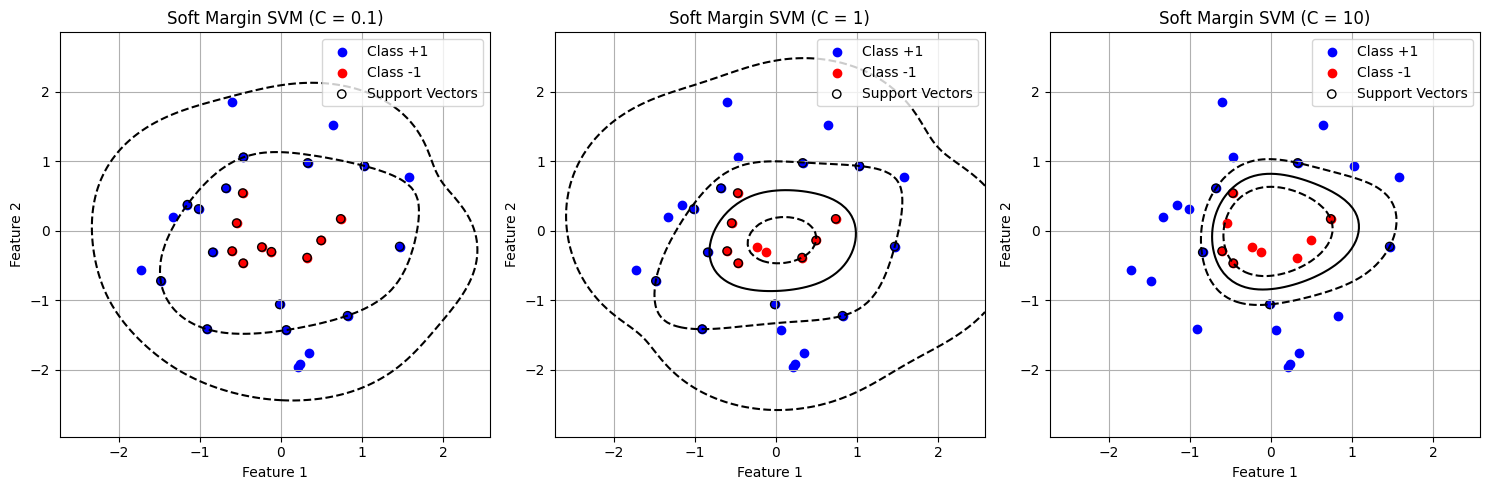

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Generate synthetic data for a nonlinear problem
np.random.seed(42)
X = np.random.randn(30, 2)  # 30 data points, 2 features
y = np.sign(X[:, 0]**2 + X[:, 1]**2 - 0.7)  # Nonlinear decision boundary (circle)
y[y == 0] = 1  # Ensure all labels are ±1

# Define different values of C to observe its effect
C_values = [0.1, 1, 10]
decision_boundaries = []

# Fit SVM models for different C values
for C in C_values:
    svm = SVC(kernel='rbf', C=C, gamma=1.0)  # RBF kernel
    svm.fit(X, y)
    decision_boundaries.append(svm)

# Visualization
x1_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
x2_range = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_grid = np.c_[X1.ravel(), X2.ravel()]

plt.figure(figsize=(15, 5))
for i, (C, svm) in enumerate(zip(C_values, decision_boundaries)):
    plt.subplot(1, 3, i + 1)
    decision_values = svm.decision_function(X_grid).reshape(X1.shape)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class +1')
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1')
    plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], edgecolors='k', facecolors='none', label='Support Vectors')
    plt.contour(X1, X2, decision_values, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
    plt.title(f'Soft Margin SVM (C = {C})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


### Hinge Loss

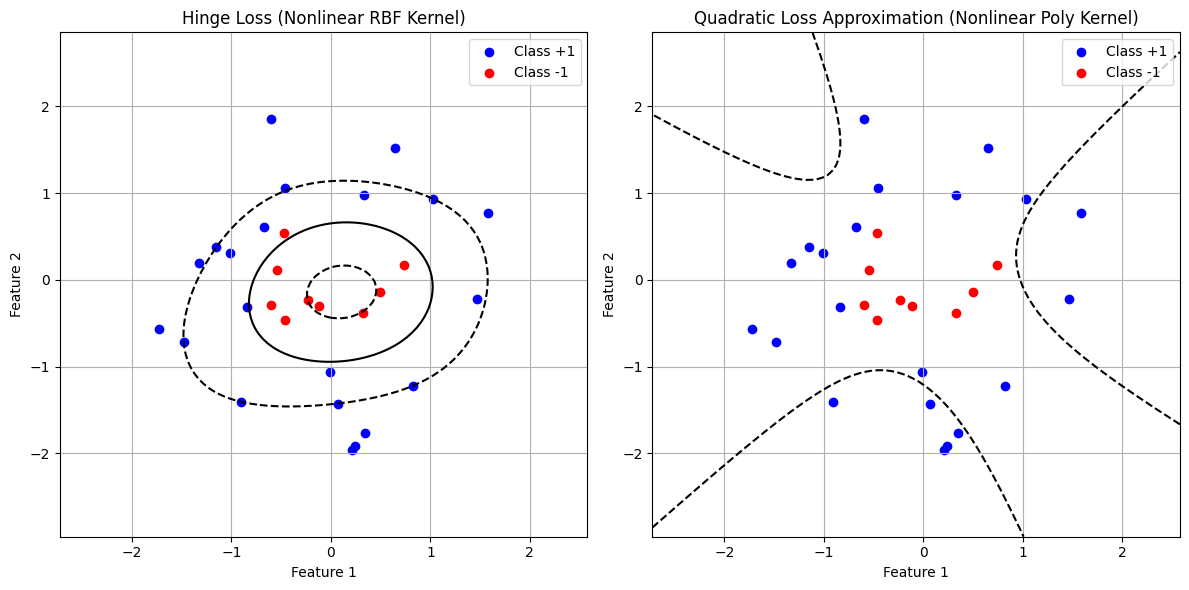

In [17]:
from sklearn.svm import SVC

# Fix the regularization parameter
C = 1

# Train SVM models with hinge loss and a nonlinear kernel (RBF kernel)
svm_hinge = SVC(kernel='rbf', C=C, random_state=42)  # Hinge loss is inherent to SVC

# Train another SVM with a quadratic loss approximation using Logistic Regression with a nonlinear kernel (via RBF kernel approximation)
# We'll simulate this with a high-degree polynomial kernel as a proxy
svm_quadratic = SVC(kernel='poly', degree=3, C=C, random_state=42)

# Fit models to the data
svm_hinge.fit(X, y)
svm_quadratic.fit(X, y)

# Decision function values for visualization
decision_hinge = svm_hinge.decision_function(X_grid).reshape(X1.shape)
decision_quadratic = svm_quadratic.decision_function(X_grid).reshape(X1.shape)

# Visualization
plt.figure(figsize=(12, 6))

# Hinge loss with nonlinear kernel
plt.subplot(1, 2, 1)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class +1')
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1')
plt.contour(X1, X2, decision_hinge, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
plt.title('Hinge Loss (Nonlinear RBF Kernel)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

# Quadratic loss approximation with nonlinear kernel
plt.subplot(1, 2, 2)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class +1')
plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='Class -1')
plt.contour(X1, X2, decision_quadratic, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
plt.title('Quadratic Loss Approximation (Nonlinear Poly Kernel)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Questions and Answers

Question: How does the dual formulation of SVM relate to the primal problem?  
- Answer: The dual reformulates the optimization problem to depend only on dot products (\(x_i^\top x_j\)), enabling the use of kernels for nonlinear separability. It is computationally efficient, especially for high-dimensional data.

Question: Why is hinge loss used in SVMs?  
- Answer: Hinge loss penalizes misclassified or near-margin points linearly, promoting a large margin. It simplifies optimization while being robust to outliers compared to quadratic loss.

Question: How can SVMs handle large datasets?  
- Answer: Use linear SVMs with stochastic gradient descent (SGD) for scalability, or approximate kernel methods like the Nyström approximation or random Fourier features to reduce computational complexity.

Question: Why do SVMs result in sparse solutions, and what are they?  
- Answer: A sparse solution involves most dual variables (\(\alpha_i\)) being zero, meaning only a few data points (support vectors) contribute to the decision boundary. This happens because SVMs optimize for points near or on the margin, ignoring those farther away.

Question: How does the kernel trick work in SVMs?  
- Answer: The kernel trick computes the dot product in a higher-dimensional space without explicitly mapping data into it. This allows efficient handling of nonlinear boundaries through kernel functions (e.g., RBF, polynomial).

Question: How does a one-class SVM work?  
- Answer: One-class SVM separates the majority of the data from outliers by finding a decision boundary around the dense regions in the feature space. It is widely used in anomaly detection.

Question: How does \(C\) control regularization in SVMs?  
- Answer: \(C\) balances margin size and misclassification. High \(C\) focuses on minimizing misclassification, leading to tighter margins but risking overfitting. Low \(C\) encourages a larger margin, allowing more misclassifications and improving generalization.

Question: What is the VC dimension of an SVM, and why is it important?  
- Answer: The VC (Vapnik-Chervonenkis) dimension measures the capacity of a model to classify data. For SVMs, it is bounded by the number of support vectors. A smaller VC dimension (achieved by maximizing the margin) improves generalization.

Question: Why do SVMs generalize well to unseen data?  
- Answer: SVMs maximize the margin, which reduces the VC dimension. This minimizes overfitting and improves generalization, as supported by statistical learning theory.

Question: Why is feature scaling critical for SVMs?  
- Answer: SVMs are sensitive to feature magnitudes since kernels and dot products depend on distances. Scaling ensures all features contribute equally, preventing bias from features with larger scales.